# SARIMA

$\operatorname{SARIMA}$ stands for 

- **S**easonal
- **A**uto 
- **R**egressive 
- **I**ntegrated 
- **M**oving
- **A**verage.

## What we will accomplish

In this notebook we will:
- Motivate the ARIMA model
- Give a precise specification of the model
- Discuss how to choose the hyperparamaters.
- Demonstrate how to fit a SARIMA model in python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from seaborn import set_style
set_style("whitegrid")

## Mathematical Motivation

Wold's Decomposition Theorem states that ever covariance stationary time series $y_t$ with $\mathbb{E}(y_t) = 0$ can be decomposed as

$$
y_t =  \eta_t + \sum_{j=0}^{\infty} d_j \epsilon_{t-j}
$$

where 

- $\epsilon_{t} \sim \operatorname{NID}(0,\sigma^2)$
- $d_0 = 1$
- $\displaystyle \sum_0^\infty d_j^2$ is finite.
- $P(\eta_{t+s} | y_t, y_{t-1}, y_{t-2}, \dots) = \eta_{t+s}$ for all $s>0$

So $y_t$ can, in essense, be represented as an $\operatorname{MA}(\infty)$ process plus a "deterministic part" $\eta_t$.

A great exposition written by Prof. Lawrence Christiano can be found [here](lecture_7_assets/wold.pdf).

This is the theoretical justification for using $\operatorname{MA}(q)$ models, which are finite approximations.

 Although Wold's theorem says that we could always use $\operatorname{MA}(q)$, the value of $q$ might be quite large.  Estimating this many parameters might require a lot of data.  Wold's theorem also tells us that an $\operatorname{AR}(p)$ process can be written as an $\operatorname{MA}(\infty)$, but it is nicer to only estimate $p$ parameters than infinitely many parameters!  
 
 Including both $\operatorname{AR}(p)$ and $\operatorname{MA}(q)$ parts of our model can account for both types of behavior while limiting the number of parameters to be estimated.  This leads us to $\operatorname{ARMA}$ models.

## Autoregressive Moving Average (ARMA) models

Combining an $\text{AR}(p)$ and $\text{MA}(q)$ sequence gives an $\text{ARMA}(p,q)$ process, that is:

$$
y_t = \alpha_1 y_{t-1} + \dots + \alpha_{p} y_{t-p} + \epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_q \epsilon_{t-q}.
$$

From this we can see that if $p=0$, then we have a $\text{MA}(q)$ process, while if $q=0$ we have an $\text{AR}(p)$ process.

We will also introduce some additional notation which will make writing these things down a little easier.

Let $B$ be the backshift operator which takes a time series $t \mapsto y_t$ and returns the backshifted time series $t \mapsto y_{t-1}$. 

Then we can rewrite the $\operatorname{ARMA}$ model as

$$
(1 - \alpha_1 B - \alpha_2 B^2 - \dots - \alpha_p B^p)y_t = (1 + \beta_1 B + \dots + \beta_q B^q) \epsilon_t
$$

We should note that any $\text{ARMA}(p,q)$ process is a stationary time series. If the time series you are attempting to forecast <b>is not</b> stationary, it will not give a good fit or forecast in the long run. This leads to the final component of the ARIMA model.

## Autoregressive Integrated Moving Average (ARIMA) models

An $\operatorname{ARIMA}(p,d,q)$ is 

$$
(1 - \alpha_1 B - \alpha_2 B^2 - \dots - \alpha_p B^p)(1-B)^d y_t = (1 + \beta_1 B + \dots + \beta_q B^q) \epsilon_t
$$
 
$1-B$ is the difference operator which takes $t \mapsto y_t$ and returns $t \mapsto y_{t} - y_{t-1}$.

So $(1-B)^d$ applies the difference operator $d$ times. 

We should choose $d$ so that the differenced time series appears stationary.

## SARIMA models

$\operatorname{SARIMA}((p,d,q),(P,D,Q,s))$ is 

$$
(1 - \mathfrak{a}_1 B^s - \mathfrak{a}_2 B^{2s} - \dots  - \mathfrak{a}_P B^{Ps})(1 - \alpha_1 B - \alpha_2 B^2 - \dots - \alpha_p B^p)(1-B^s)^d(1-B)^d y_t = (1 + \mathfrak{b}_1 B^s + \mathfrak{b}_2 B^{2s} + \dots  + \mathfrak{b}_P B^{Ps})(1 + \beta_1 B + \dots + \beta_q B^q) \epsilon_t
$$

To understand why this let's write down an example $\operatorname{SARIMA}((0,0,0),(1,0,0,7))$ model is in less awesome notation.  It is just

$$
(1 - \mathfrak{a}_1 B^7) y_t = 0
$$

which translates to

$$
y_t = \mathfrak{a}_1 y_{t-7}
$$

In other words, the seasonal part of SARIMA only regresses on lags which are multiples of $s$.

### Simulating some ARIMA data

Let's generate some synthetic data which follows the $\operatorname{ARIMA}(2,1,2)$ process:

$$
y_t - y_{t-1} = 0.5y_{t-1} - 0.2y_{t-2} + \epsilon_{t} + 0.7\epsilon_{t-1} + 0.4\epsilon_{t-2}
$$


In [2]:
import statsmodels.tsa.api as sm

In [3]:
np.random.seed(12345)
arparams = np.array([0.5, -0.2])
maparams = np.array([0.7, 0.4])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = sm.arma_generate_sample(ar, ma, 1000).cumsum() # taking cumulative sum of ARMA process to get y, i.e. "integrating" once.

model = sm.ARIMA(y, order = (2, 1, 2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1397.218
Date:                Fri, 15 Mar 2024   AIC                           2804.436
Time:                        10:36:39   BIC                           2828.970
Sample:                             0   HQIC                          2813.761
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4510      0.078      5.755      0.000       0.297       0.605
ar.L2         -0.1954      0.060     -3.266      0.001      -0.313      -0.078
ma.L1          0.7489      0.073     10.219      0.000       0.605       0.893
ma.L2          0.4384      0.049      8.947      0.000       0.342       0.534
sigma2         0.9586      0.042     22.591      0.000       0.875       1.042
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.81
Prob(Q):                              1.00   Prob(JB):                         0.15
Heteroskedasticity (H):               0.87   Skew:                             0.14
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The summary shows that we obtained good estimates of the true parameters!

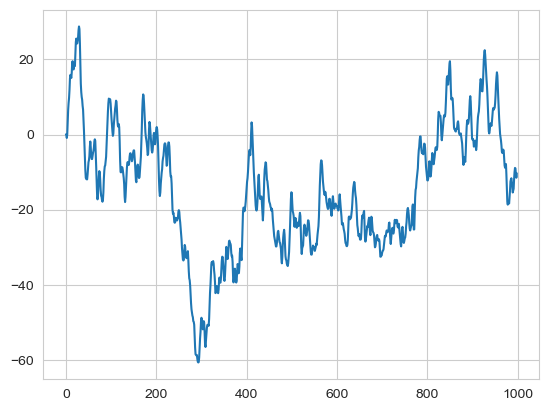

In [4]:
# Plot of the time series

plt.plot(range(999), y[1:]) #
plt.show()

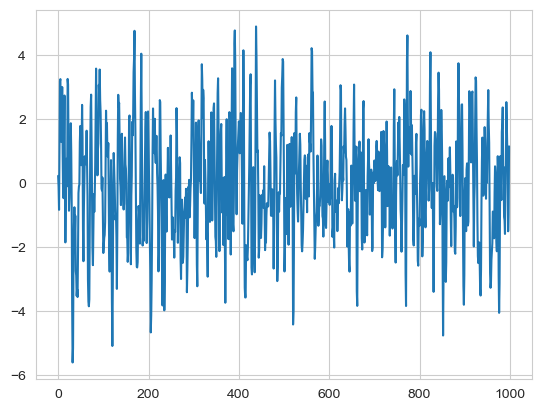

In [5]:
# plot of the first differences

plt.plot(range(999), y[1:] - y[:-1]) 
plt.show()

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

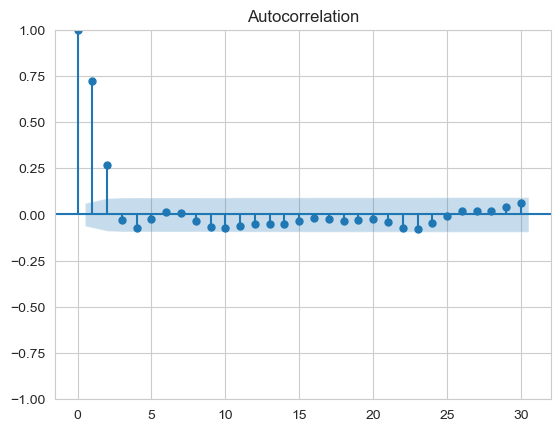

In [7]:
plot_acf(y[1:] - y[:-1])
plt.show()

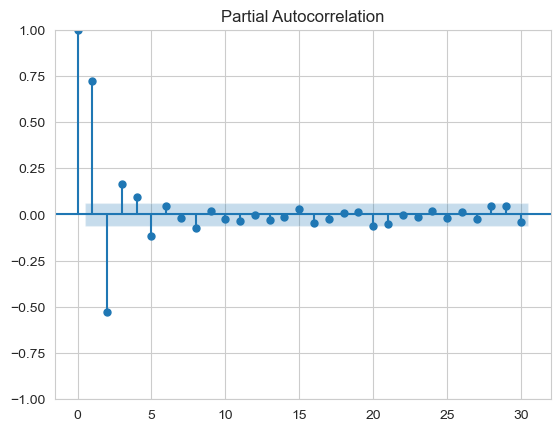

In [8]:
plot_pacf(y[1:] - y[:-1])
plt.show()

Remember that 

- the order of a pure MA model can be identified from the ACF plot, and it will appear to exponentially decay on the PACF plot.
- the order of a pure AR model can be identified from the PACF plot, and it will appear to exponentially decay on the ACF plot.

An ARMA model will have some combination of these and this can muddle identification of the hyperparameters from these plots.  In practice hyperparameter selection is usually done automatically either in cross validation or by selecting the model with the lowest [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion).  However these plots can still be useful, as we will see a bit later when we do some forecasting on real data.


### Using SARIMA on real data

We introduce a new dataset sourced from [Kaggle](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data).

The original dataset was quite large:  it tracked the sales of $50$ different items in $10$ different store locations over $5$ years.  I trimmed it down to sales of one product at one particular grocery store over a $5$ year period.

In [9]:
df_train = pd.read_csv('../../data/sales_train.csv', index_col=0, parse_dates=['date']) # 2013,2014,2015, 2016
df_test = pd.read_csv('../../data/sales_test.csv', index_col=0, parse_dates=['date']) # 2017

In [10]:
df_train.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


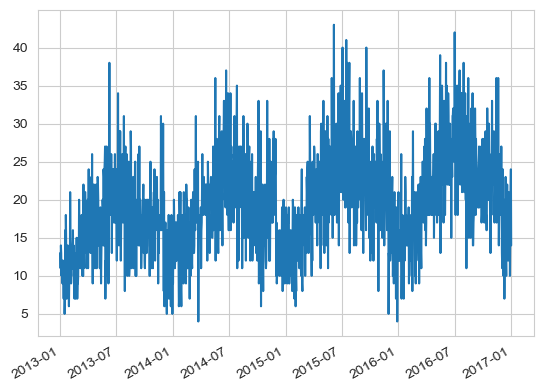

In [11]:
plt.plot(df_train.date, df_train.sales)
plt.gcf().autofmt_xdate()

plt.show()

There appears to be both an upward trend and yearly seasonality.

I will fit a simple linear regression to estimate the trend, and then model the residuals as purely seasonal.

I will model the seasonal component by first averaging the 4 years and then using a 2 week centered rolling average.

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
lr = LinearRegression()
lr.fit(df_train.index.values.reshape(-1,1),df_train.sales)

LinearRegression()

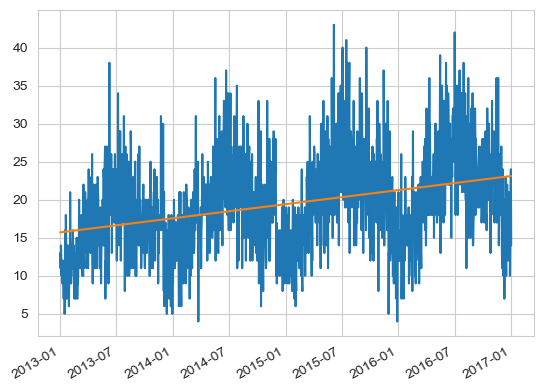

In [14]:
plt.plot(df_train.date, df_train.sales)
plt.plot(df_train.date, lr.predict(df_train.index.values.reshape(-1,1)))
plt.gcf().autofmt_xdate()

plt.show()

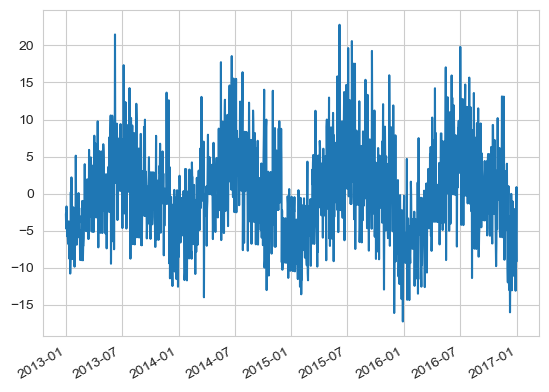

In [15]:
sales_minus_trend = np.array(df_train.sales - lr.predict(df_train.index.values.reshape(-1,1)))
df_train['sales_minus_trend'] = sales_minus_trend.tolist()

plt.plot(df_train.date, df_train.sales_minus_trend)
plt.gcf().autofmt_xdate()

plt.show()

In [16]:
# Taking the mean by day of year.
average_year = df_train.sales_minus_trend.groupby(df_train.date.dt.dayofyear).mean()

In [17]:
# Note that 2016 is a leap year, so we have 366 days.
average_year.shape

(366,)

In [18]:
# Defining my 2 week rolling average year.  
# I am choosing a centered rolling average.
# The first and last week are set to their constant means
# everything in between is a mean of all sales from one week before to one week after.

roll_avg_year = np.zeros(366)

for i in range(7):
    roll_avg_year[i] = average_year.iloc[:7].mean()
    roll_avg_year[-i] = average_year.iloc[-7:].mean()

for i in range(7, 366-6):
    roll_avg_year[i] = average_year.iloc[i-7:i+7].mean()

In [19]:
# Checking the day counts
df_train.groupby(df_train.date.dt.year).count()

,date,sales,sales_minus_trend
date,,,
2013,365,365,365
2014,365,365,365
2015,365,365,365
2016,366,366,366


In [20]:
# index number 1154 is the leap day
df_train.date[df_train.date.dt.month == 2]

31     2013-02-01
32     2013-02-02
33     2013-02-03
34     2013-02-04
35     2013-02-05
          ...    
1150   2016-02-25
1151   2016-02-26
1152   2016-02-27
1153   2016-02-28
1154   2016-02-29
Name: date, Length: 113, dtype: datetime64[ns]

In [21]:
df_train.date.iloc[1154].dayofyear

60

In [22]:
# This is the rolling average with leap day eliminated.
roll_avg_365 = np.concatenate([roll_avg_year[:60], roll_avg_year[61:]])

In [23]:
roll_avg_365.shape

(365,)

In [24]:
roll_avg_preds = np.concatenate([roll_avg_365, roll_avg_365, roll_avg_365, roll_avg_year])

In [25]:
# checking that these have the correct shapes
roll_avg_preds.shape, df_train.shape

((1461,), (1461, 3))

In [26]:
lr_train_preds = lr.predict(df_train.index.values.reshape(-1,1))
roll_train_preds = lr_train_preds + roll_avg_preds
roll_train_res = df_train.sales - roll_train_preds

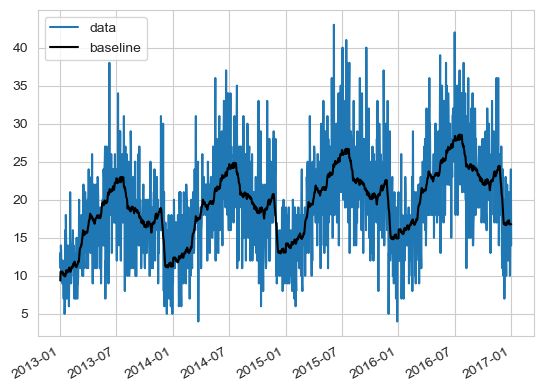

In [27]:
plt.plot(df_train.date, df_train.sales, label = 'data')
plt.plot(df_train.date, roll_train_preds, 'k',label = 'baseline')
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

It would have been difficult to capture the extra "bump" towards the end of the year without this rolling seasonal average component.

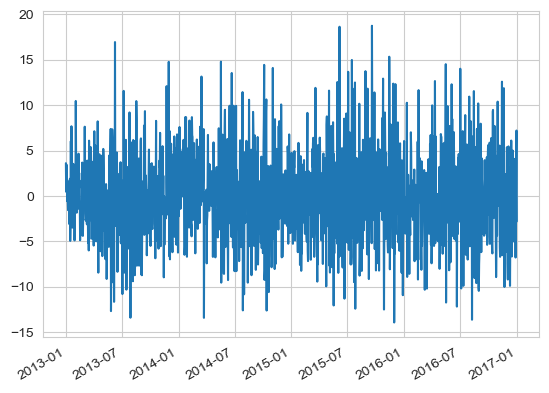

In [28]:
plt.plot(df_train.date, roll_train_res)
plt.gcf().autofmt_xdate()

plt.show()

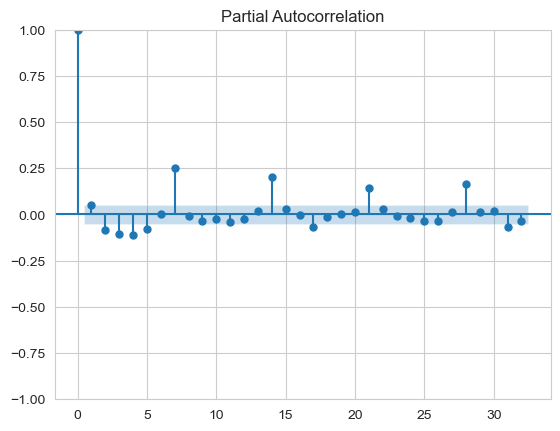

In [29]:
plot_pacf(roll_train_res)
plt.show()

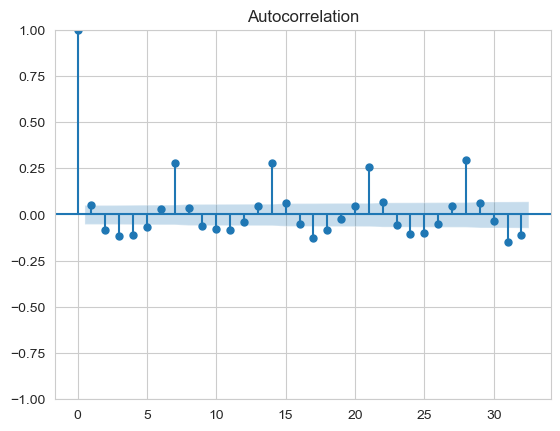

In [30]:
plot_acf(roll_train_res)
plt.show()

These plots show clear seaonsal behavior with a period of $7$.  

This makes sense:  our rolling average was able to account for patterns at the time scale of the whole year.  However since each year begins on a different day of the week, our yearly average is ignoring weekly patterns. People have different shopping habits on the weekend.  Weekly and biweekly pay dates can also contribute to differences in shopping behavior.

Fitting a SARIMA model with a season of $7$ makes sense.  I played around a bit with the other hyperparameters which took some time, but I skip that play here for brevity.

In [31]:
arima = sm.ARIMA(roll_train_res, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
fitted_arima = arima.fit(method='innovations_mle',low_memory=True, cov_type='none')

In [32]:
fitted_arima.fittedvalues

0       0.013307
1       0.096185
2      -0.025866
3       0.115715
4       0.013180
          ...   
1456   -1.504490
1457   -1.364791
1458   -0.775409
1459    1.153487
1460    2.873993
Length: 1461, dtype: float64

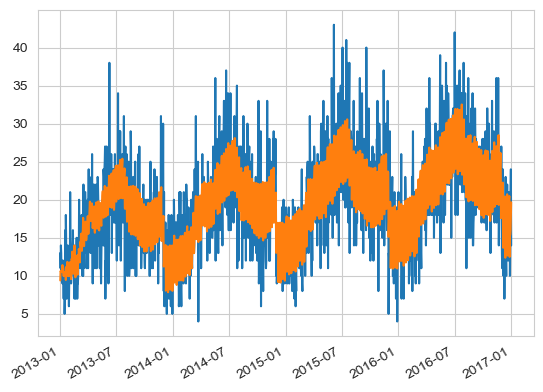

In [33]:
#plt.plot(df_train.date, df_train.sales)
plt.plot(df_train.date, df_train.sales)
plt.plot(df_train.date, roll_train_preds + fitted_arima.fittedvalues)
plt.gcf().autofmt_xdate()

plt.show()

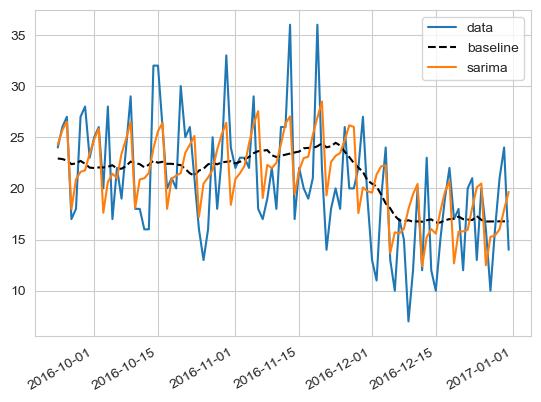

In [34]:
plt.plot(df_train.date.iloc[-100:], df_train.sales.iloc[-100:], label = 'data')
plt.plot(df_train.date.iloc[-100:], roll_train_preds[-100:], '--k',label = 'baseline')
plt.plot(df_train.date.iloc[-100:], roll_train_preds[-100:] + fitted_arima.fittedvalues[-100:], label = 'sarima')
plt.gcf().autofmt_xdate()

plt.legend()

plt.show()

Wow!  We are really doing a good job of modeling the weekly highs and lows here.

Let's see which model performs better on our test set.

In [35]:
from sklearn.metrics import mean_squared_error

In [36]:
# Making the baseline prediction and arima prediction on the testing data.

lr_roll_y_preds = lr.predict(df_test.index.values.reshape(-1,1)) + roll_avg_365
lr_roll_arima_y_preds = lr_roll_y_preds + fitted_arima.forecast(365)

In [37]:
mean_squared_error(df_test.sales,lr_roll_y_preds)

35.391462008393034

In [38]:
mean_squared_error(df_test.sales, lr_roll_arima_y_preds)

26.31583550886365

Fitting the residuals of our baseline model with SARIMA substantially improved model performance!

# Next Steps for Time Series

This is our final notebook on time series!

We have touched on some of the most basic concepts regarding time series analysis and forecasting. While we do present additional content in the time series `Problem Sessions` and `Practice Problems` notebooks, you may wish to get more detailed information on this subject.

Some useful books are:

1. <a href="http://site.iugaza.edu.ps/nbarakat/files/2010/02/Analysis_of_Time_Series_An_Introduction.pdf">The Analysis of Time Series</a>, by Chris Chatfield

2. <a href="https://mybiostats.files.wordpress.com/2015/03/time-series-analysis-and-its-applications-with-examples-in-r.pdf">Time Series Analysis & its Applications</a>, by Robert H. Shumway and David S. Stoffer.

3. <a href="https://otexts.com/fpp3/">Forecasting: Principles and Practice</a>, by Rob J Hyndman and George Athanasopoulos.

4. Forecasting with Exponential Smoothing: The State Space Approach, by Rob Hyndman, Anne B. Koehler, J. Keith Ord, Ralph D. Snyder

5. Time Series Analysis by James D. Hamilton

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.  Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)